In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(4)
np.random.seed(4)

In [2]:
BATCH_SIZE = 128
NUM_ITERS = int(1e4)
CRITERION = nn.CrossEntropyLoss()  


In [3]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

EPOCHS = int(NUM_ITERS / (len(trainset) / BATCH_SIZE))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(DEVICE)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cuda


In [4]:

# Block

class ResidualBlock(nn.Module):

    def __init__(self, stride=1, padding=1, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn1 = nn.BatchNorm2d(8)

        self.relu1 = nn.ReLU()        

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn2 = nn.BatchNorm2d(8)

        self.relu2 = nn.ReLU()       

         


    def forward(self, x):

        residual = x

        out = self.conv1(x)

        if self.batch_norm:
            out = self.bn1(out)

        out = self.relu1(out)

        out = self.conv2(out)

        if self.batch_norm:
            out = self.bn2(out)

        out += residual

        out = self.relu2(out)

        return out

# Model
class CNNModel(nn.Module):
    def __init__(self, batch_norm=False, N=10):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 28 x 28

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=2, padding=0)
        # Size: 12 x 12

        # Dynamic block num
        self.blocks = nn.Sequential(*[ResidualBlock(batch_norm=batch_norm) for _ in range(N)])
        # Size: 12 x 12

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=0)                    
        # Size: 5 X 5

        self.fc1 = nn.Linear(5 * 5 * 4, 100, bias=True) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10, bias=False) 


    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        out = self.blocks(out)         # How is the shape the same after this???
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [5]:

def calc_accuracy(model, train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images
        images, labels = images.to(DEVICE), labels.to(DEVICE)        

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(model): 
    print(f'Training for {EPOCHS} epochs')
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
    accuracy = {'train': [], 'test': []}

    for epoch in range(EPOCHS):    
        for i, (images, labels) in enumerate(train_loader): 
            # This will load batch_size amount of samples
            images, labels = images.requires_grad_().to(DEVICE), labels.to(DEVICE)                     

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = CRITERION(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(model, train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy(model) # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)

## a) Plot Train and Test accuracy

Training for 25 epochs
Epoch: 0 Loss: 2.2685112953186035. Train Accuracy: 13.191999435424805, Test Accuracy: 13.239999771118164
Epoch: 1 Loss: 2.0367963314056396. Train Accuracy: 26.0679988861084, Test Accuracy: 26.809999465942383
Epoch: 2 Loss: 1.990281343460083. Train Accuracy: 27.983999252319336, Test Accuracy: 29.049999237060547
Epoch: 3 Loss: 1.8291699886322021. Train Accuracy: 30.673999786376953, Test Accuracy: 31.479999542236328
Epoch: 4 Loss: 1.9209339618682861. Train Accuracy: 33.49599838256836, Test Accuracy: 33.86000061035156
Epoch: 5 Loss: 1.7385276556015015. Train Accuracy: 36.84199905395508, Test Accuracy: 37.439998626708984
Epoch: 6 Loss: 1.7754242420196533. Train Accuracy: 38.947998046875, Test Accuracy: 38.96999740600586
Epoch: 7 Loss: 1.5626598596572876. Train Accuracy: 34.369998931884766, Test Accuracy: 34.20000076293945
Epoch: 8 Loss: 1.592860460281372. Train Accuracy: 42.657997131347656, Test Accuracy: 42.5
Epoch: 9 Loss: 1.654094934463501. Train Accuracy: 43.93199

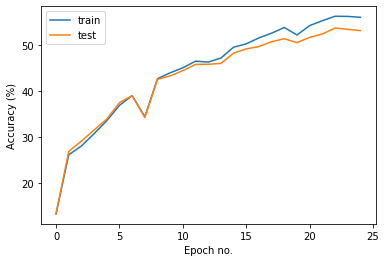

In [6]:

resdiual_network = CNNModel().to(DEVICE)
resdiual_network_history = train(resdiual_network)
resdiual_network_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')

Training for 51 epochs
Epoch: 0 Loss: 2.184399127960205. Train Accuracy: 18.091999053955078, Test Accuracy: 17.579999923706055
Epoch: 1 Loss: 1.9781843423843384. Train Accuracy: 28.599998474121094, Test Accuracy: 29.219999313354492
Epoch: 2 Loss: 2.1509909629821777. Train Accuracy: 34.64999771118164, Test Accuracy: 35.52000045776367
Epoch: 3 Loss: 1.7879705429077148. Train Accuracy: 35.22800064086914, Test Accuracy: 35.90999984741211
Epoch: 4 Loss: 1.6254431009292603. Train Accuracy: 33.83799743652344, Test Accuracy: 34.029998779296875
Epoch: 5 Loss: 1.4392951726913452. Train Accuracy: 41.06599807739258, Test Accuracy: 40.80999755859375
Epoch: 6 Loss: 1.7015838623046875. Train Accuracy: 41.055999755859375, Test Accuracy: 40.959999084472656
Epoch: 7 Loss: 1.6818602085113525. Train Accuracy: 39.641998291015625, Test Accuracy: 39.40999984741211
Epoch: 8 Loss: 1.6117048263549805. Train Accuracy: 42.53999710083008, Test Accuracy: 42.03999710083008
Epoch: 9 Loss: 1.4976998567581177. Train Ac

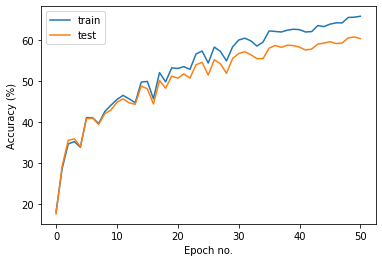

In [7]:
# Just for fun, as a straight comparison to last week
EPOCHS = 51
resdiual_network = CNNModel().to(DEVICE)
resdiual_network_history = train(resdiual_network)
resdiual_network_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')

## b) Accuracy and convergence comparison to ConvBlock with Batch Norm

From these experiments, we can see that the residual network is able to outperform last week's model by a significant margin. The CNN with batch normalization was only able to achieve 55.6% train accuracy, 52.5% test accuracy and a loss of 1.36 by epoch 25, or around 10k iterations (these are numbers are from my pdf last week). This is in comparison to the residual network which achieved 56% train accuracy, 53% test, and a loss of 1.26. However, one could still say that this was just due to the randomness inherent in the initialization. So I decided to train for 51 epochs or around 20k iterations to have a one to one comparison with last week. Here we see a drastic difference; the residual network performs around 5% better on both train and test, as well as a loss that is almost 15% lower (.85 vs .99).